In [1]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r_score": r_score,}

In [2]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_logP_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=False,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    # elif "angle" in feature_name or "distance" in feature_name:
    #     features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=False,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

merged_dataframe = pd.concat([train_df, test_df], axis=0)
merged_dataframe = test_df.copy()

True
183
['f_freedom', 'distance_between_atoms_in_cycle_and_f_group', 'PPSA5', 'mol_num_cycles', 'nFRing', 'nAHRing', 'angle_R1X1R2', 'nF', 'identificator', 'mol_weight', 'dipole_moment', 'nHRing', 'nO', 'PBF', 'nC', 'angle_X2X1R1', 'nARing', 'angle_R2X2R1', 'cis/trans', 'PNSA5', 'FPSA3', 'naRing', 'tpsa+f', 'mol_volume', 'RPCS', 'f_atom_fraction', 'GeomShapeIndex', 'WPSA5', 'TASA', 'f_to_fg', 'dihedral_angle', 'nFARing', 'distance_between_atoms_in_f_group_centers', 'avg_atoms_in_cycle', 'angle_X1X2R2', 'nFHRing', 'nFAHRing', 'chirality', 'pKa', 'logP']
mol_volume outliers indexes: [127]
f_atom_fraction outliers indexes: [124]
distance_between_atoms_in_f_group_centers outliers indexes: [ 35 167]
logP outliers indexes: [82, 83]
Remains rows:172, amount of features: 40
147 25


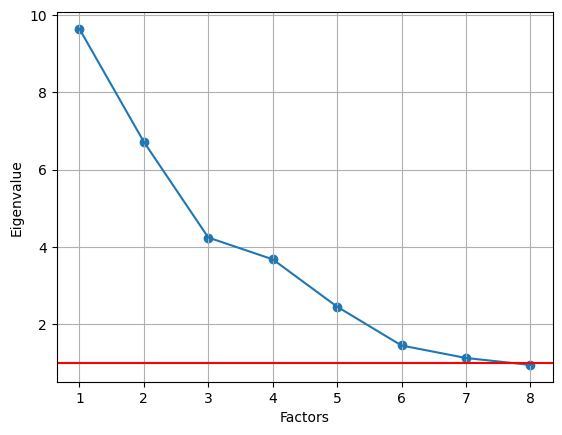

In [5]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# train_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\train_logP_v3.csv', index_col=0)
# test_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\test_logP_v3.csv', index_col=0)

features_to_analyse = []
for feature_name in merged_dataframe.columns:
    if len(merged_dataframe[feature_name].unique()) != 1:
        features_to_analyse.append(feature_name)

if 'fold_id' in features_to_analyse:
    features_to_analyse.remove('fold_id')

fa = FactorAnalyzer(rotation=None)

df_features = merged_dataframe[features_to_analyse]
# df_features = StandardScaler().fit_transform(df_features)
fa.fit(df_features)

ev, _ = fa.get_eigenvalues()
for index, en_value in enumerate(ev):
    if en_value < 1:
        break
index += 1

plt.scatter(range(1, index + 1), ev[:index])
plt.plot(range(1, index + 1), ev[:index])
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y = 1, color='r')
plt.grid()
plt.show()

In [6]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(df_features)
kmo_model

nan

In [7]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

df_for_bartlett_sphericity = StandardScaler().fit_transform(df_features)
chi_square_value, p_value = calculate_bartlett_sphericity(df_for_bartlett_sphericity)
print(f"statistics: {chi_square_value}, p-value: {p_value}")

statistics: nan, p-value: nan


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\factor_analyzer\factor_analyzer.py:109: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


In [9]:
from sklearn.preprocessing import StandardScaler

n_factors = 7

fa = FactorAnalyzer(n_factors=n_factors, rotation="varimax")

fa.fit(df_features)

fa_load = pd.DataFrame(fa.loadings_,index=df_features.columns)
fa_load.style.background_gradient(cmap="coolwarm")

,0,1,2,3,4,5,6
f_freedom,-0.352327,0.177754,0.158050,-0.097526,-0.135266,0.855036,0.086603
distance_between_atoms_in_cycle_and_f_group,0.938361,0.021279,0.206081,-0.018267,-0.040656,-0.122981,-0.010949
PPSA5,-0.021604,0.226939,-0.020210,0.380846,0.794125,-0.085409,-0.108588
mol_num_cycles,0.272345,0.772721,0.329234,0.395322,-0.128880,0.124236,0.056168
nFRing,-0.024173,0.886936,0.137471,-0.070816,0.106653,-0.100993,0.263537
angle_R1X1R2,0.977968,0.119535,-0.012994,-0.108429,0.026483,0.029256,-0.027178
nF,0.478106,-0.145688,-0.042155,-0.074995,0.702236,-0.457110,-0.129476
identificator,0.193035,0.067503,-0.025849,-0.777765,-0.140757,0.196699,0.010288
mol_weight,0.354754,0.277185,0.583134,0.399288,0.240731,-0.336996,-0.198720
dipole_moment,0.110195,-0.119720,0.349011,0.050305,-0.063577,-0.076611,0.494027


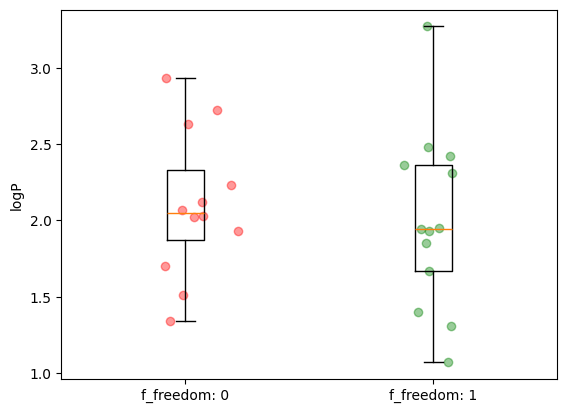

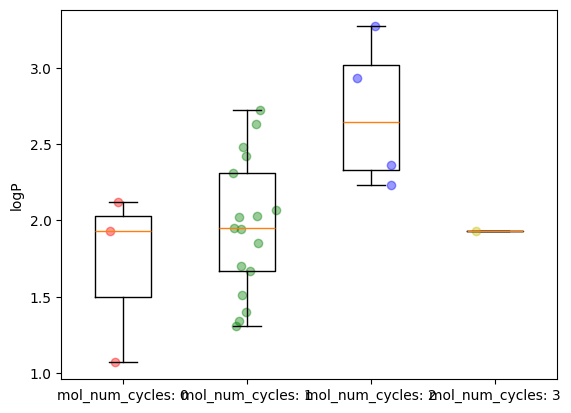

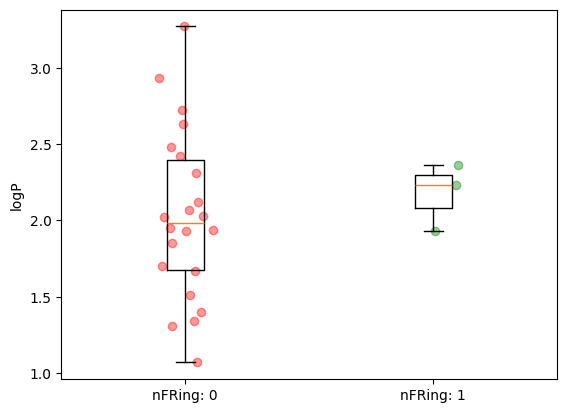

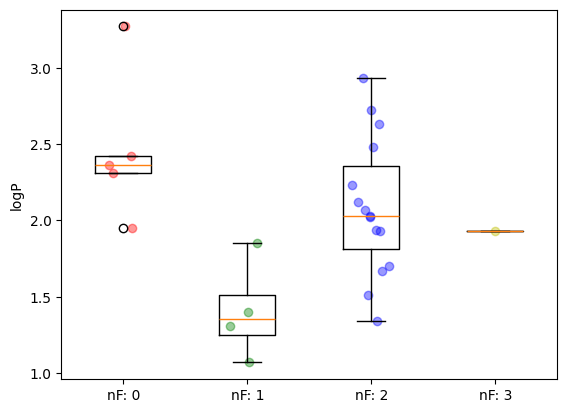

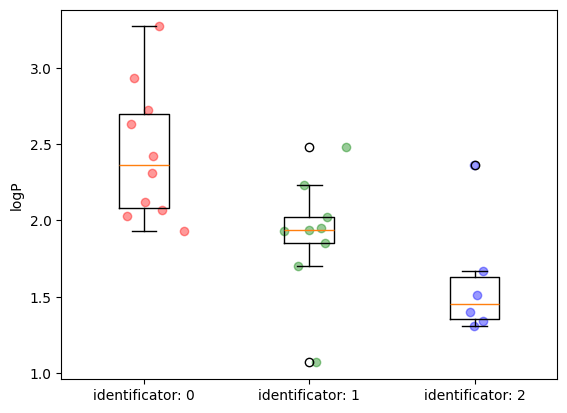

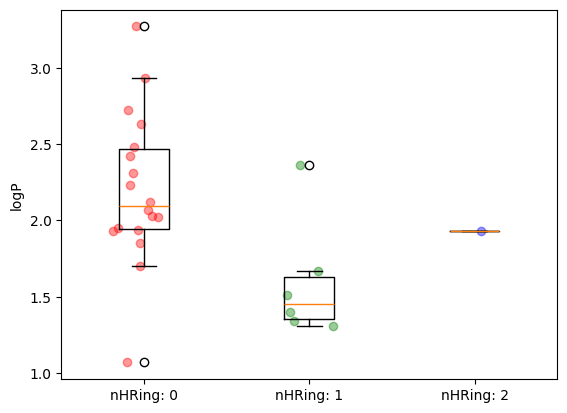

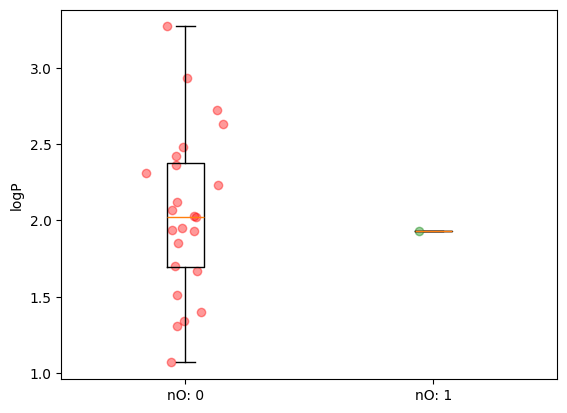

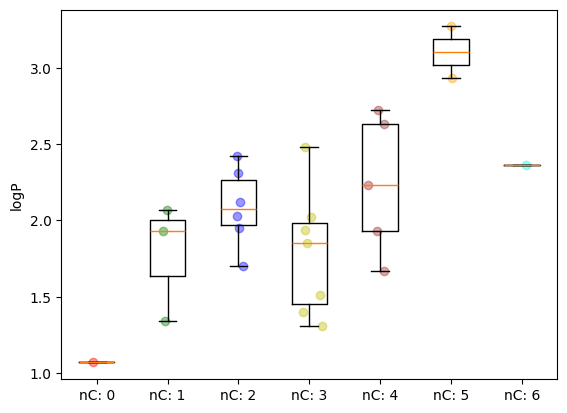

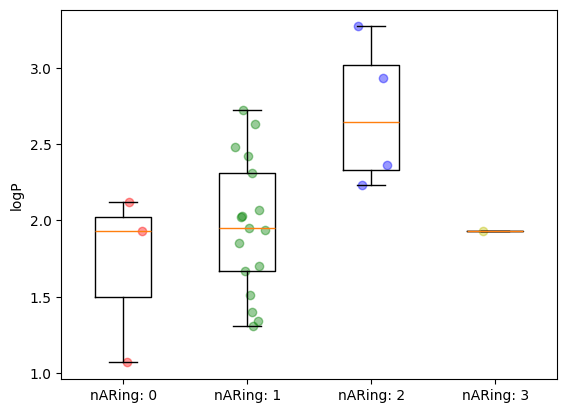

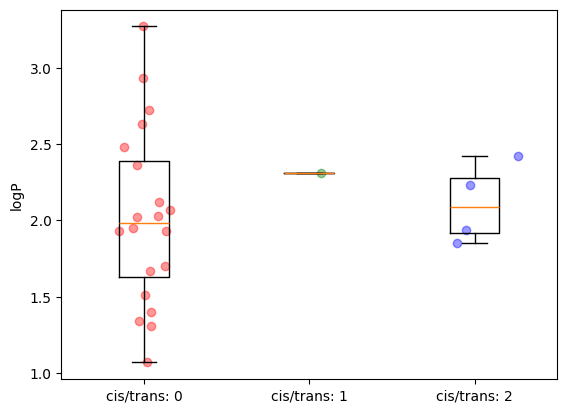

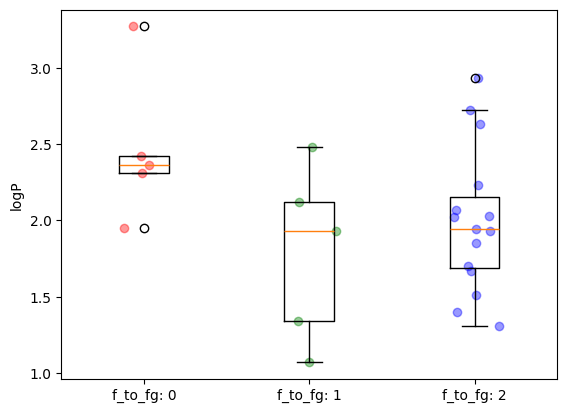

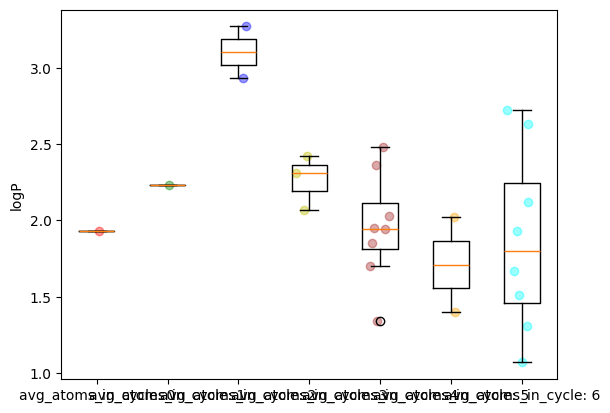

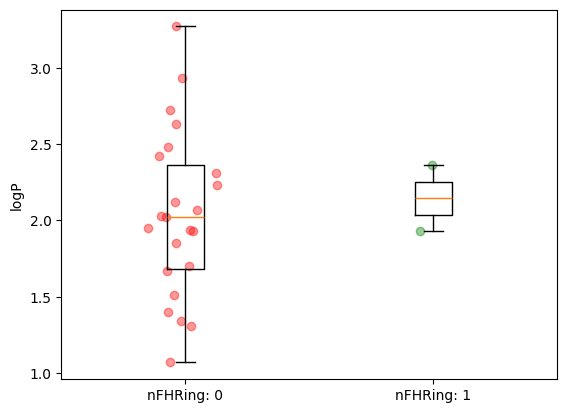

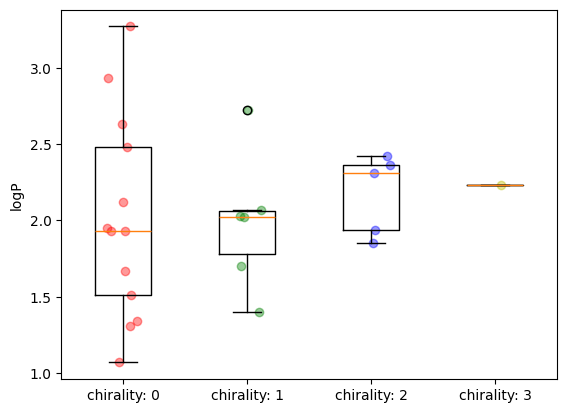

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

feature_names = df_features.columns

for factor_index in range(n_factors):
    factor_representation = fa.loadings_[:, factor_index]

    for feature_index in range(len(feature_names)):
        if abs(factor_representation[feature_index]) < 0.0:
            continue

        if feature_names[feature_index] == 'logP':
            continue
        
        feature_name = feature_names[feature_index]
        # print(f"Factor: {factor_index}, feature: {feature_names[feature_index]}, representation: {factor_representation[feature_index]}, logP repsentation: {factor_representation[-1]}")

        _x = list(df_features['logP'])
        _y = list(df_features[feature_names[feature_index]])
        x, y = [], []
        for index in range(len(_x)):
            if _y[index] == 0 and ("angle" in feature_names[feature_index] or "distance" in feature_names[feature_index]):
                continue
            else:
                x.append(_x[index])
                y.append(_y[index])


        # print(f"Amount of feature: {feature_name}: {len(set(y))}")
        if len(set(y)) > 10:
            continue
            slope, intercept, r, p, se = linregress(x, y)
            y_line = [slope * xi + intercept for xi in x]

            plt.scatter(x=x, y=y, color="red")
            plt.plot(x, y_line, color="blue")
            plt.xlabel('logP')
            plt.ylabel(feature_names[feature_index])
            plt.show()

        else:
            vals, names, xs = [],[],[]
            for i, unique_values in enumerate(sorted(set(y))):
                values = df_features[df_features[feature_name] == unique_values]['logP']
                vals.append(values)
                names.append(f"{feature_name}: {i}")
                xs.append(np.random.normal(i + 1, 0.08, values.shape[0])) 
            
            plt.boxplot(vals, labels=names)
            plt.ylabel('logP')
            palette = ['r', 'g', 'b', 'y', 'brown', 'orange', 'cyan', 'purple', 'olive']
            for x, val, c in zip(xs, vals, palette):
                plt.scatter(x, val, alpha=0.4, color=c)
            plt.show()

    break
            
                


Amount of feature: f_freedom: 2
R^2 score: 0.010449115403613714
{'mse': 0.247, 'mae': 0.494, 'r_score': 0.01}


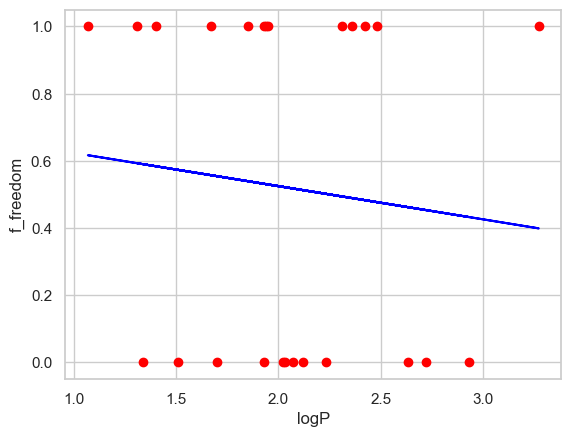

Mann-Whitney U for f_freedom: 90.50
P-value: 0.5139
There isn't any statistically significant difference between the groups


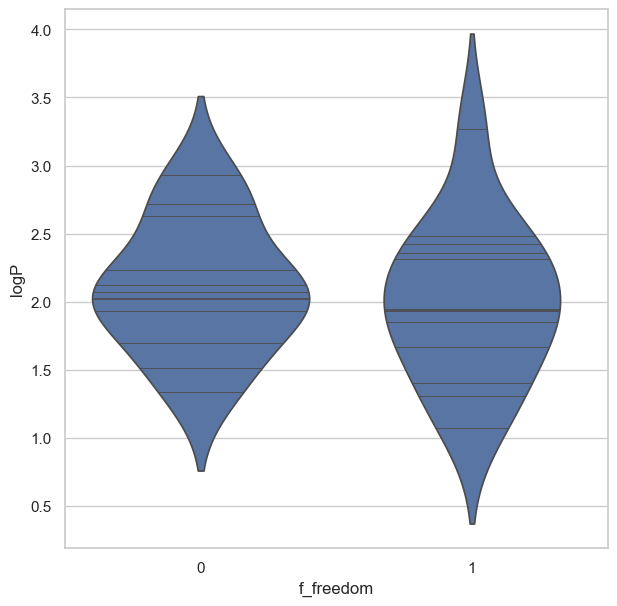

Amount of feature: distance_between_atoms_in_cycle_and_f_group: 16
R^2 score: 0.15026772085116563
{'mse': 0.469, 'mae': 0.6, 'r_score': 0.15}


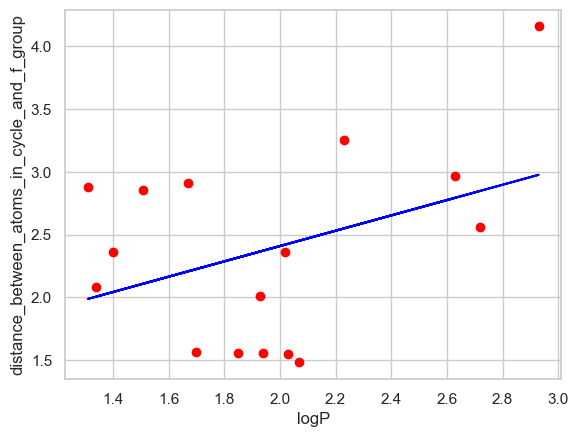

Amount of feature: PPSA5: 25
R^2 score: 0.030707671011909733
{'mse': 1.123, 'mae': 0.871, 'r_score': 0.031}


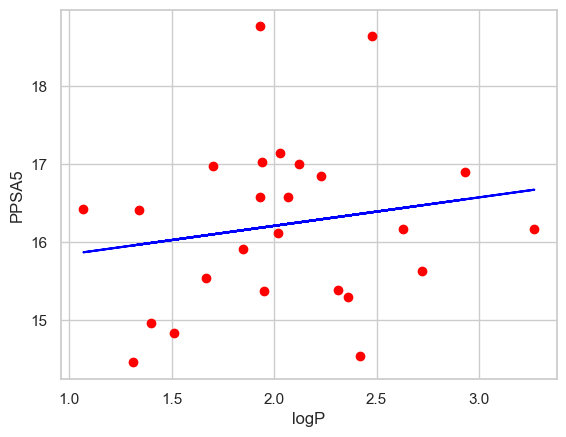

Amount of feature: mol_num_cycles: 4
R^2 score: 0.1619932758185369
{'mse': 0.357, 'mae': 0.41, 'r_score': 0.162}


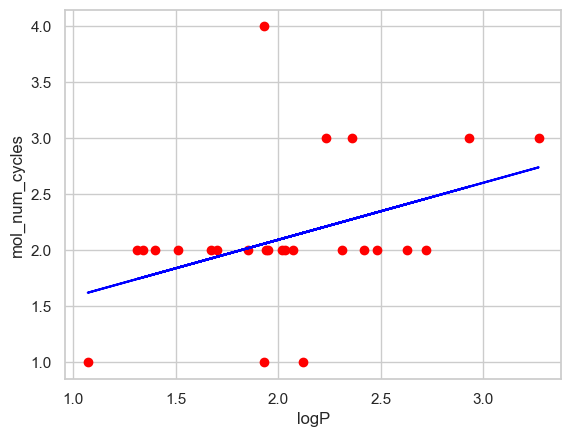

Kruskal for mol_num_cycles: 6.53
P-value: 0.0885
There isn't any statistically significant difference between the groups


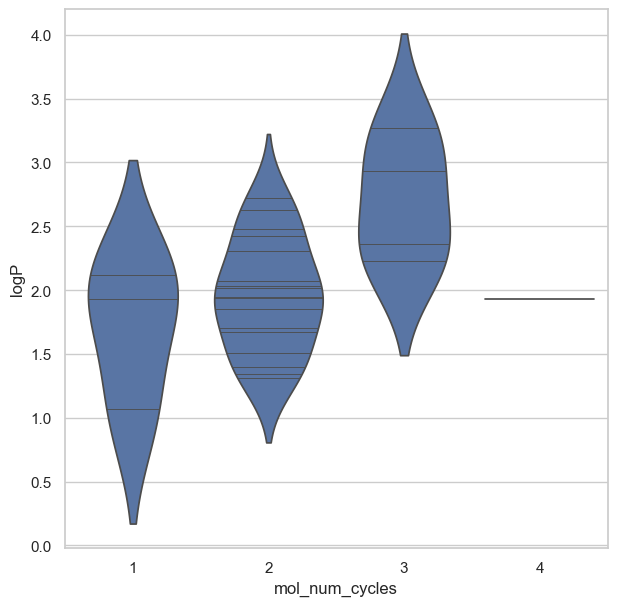

Amount of feature: nFRing: 2
R^2 score: 0.00809648239061127
{'mse': 0.105, 'mae': 0.209, 'r_score': 0.008}


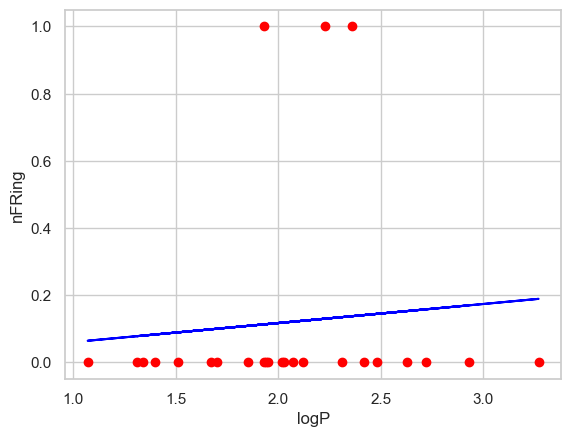

Mann-Whitney U for nFRing: 26.50
P-value: 0.6158
There isn't any statistically significant difference between the groups


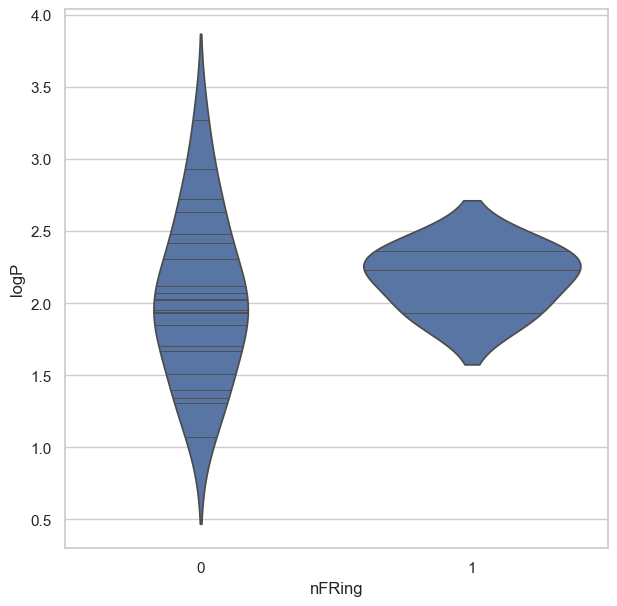

Amount of feature: angle_R1X1R2: 16
R^2 score: 0.22190210498083426
{'mse': 493.083, 'mae': 18.916, 'r_score': 0.222}


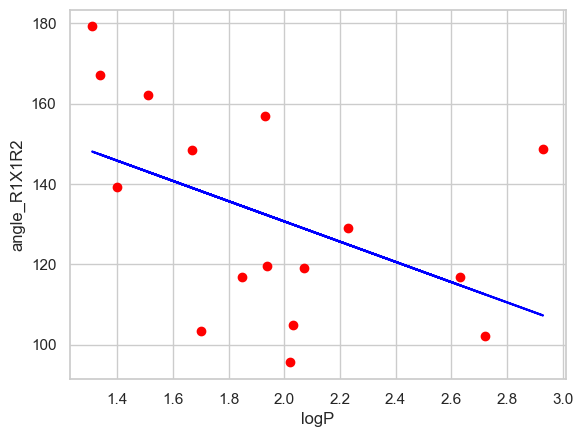

Amount of feature: nF: 4
R^2 score: 0.02383651985591659
{'mse': 0.712, 'mae': 0.756, 'r_score': 0.024}


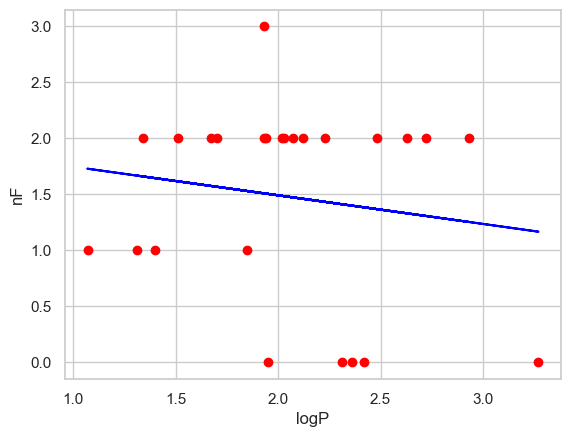

Kruskal for nF: 9.82
P-value: 0.0202
There is a statistically significant difference between the groups


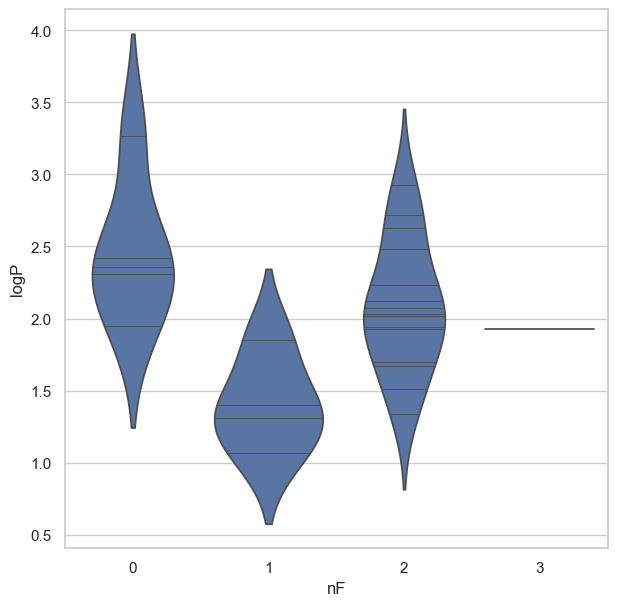

Amount of feature: identificator: 3
R^2 score: 0.43247077223475444
{'mse': 0.349, 'mae': 0.473, 'r_score': 0.432}


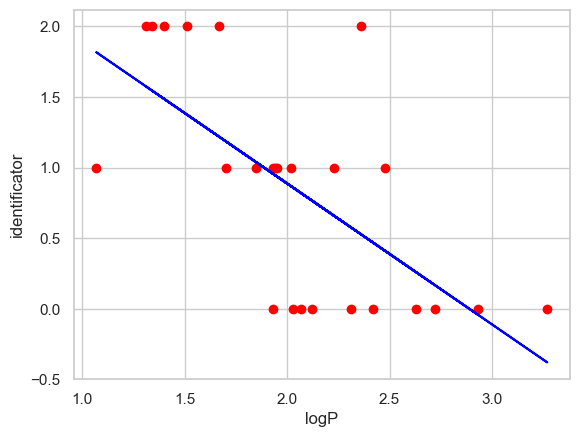

Kruskal for identificator: 11.21
P-value: 0.0037
There is a statistically significant difference between the groups


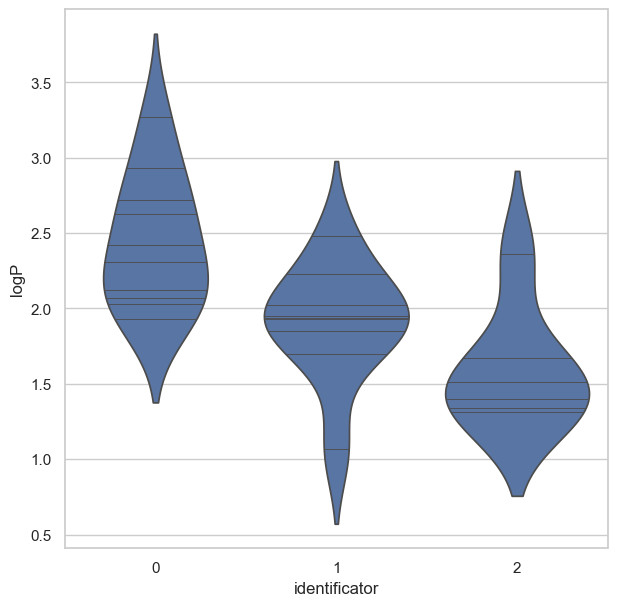

Amount of feature: mol_weight: 18
R^2 score: 0.36669636578603565
{'mse': 505.647, 'mae': 17.011, 'r_score': 0.367}


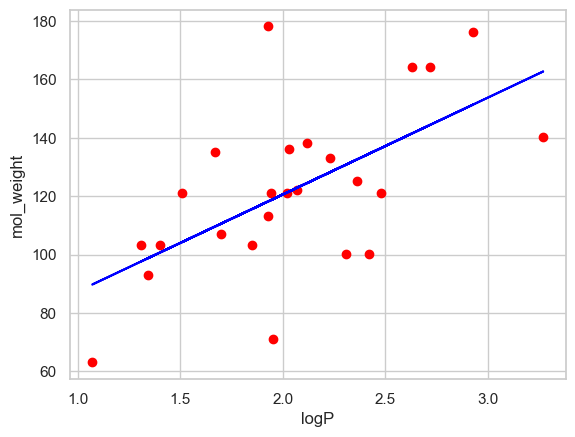

Amount of feature: dipole_moment: 25
R^2 score: 0.06660369331367313
{'mse': 0.042, 'mae': 0.161, 'r_score': 0.067}


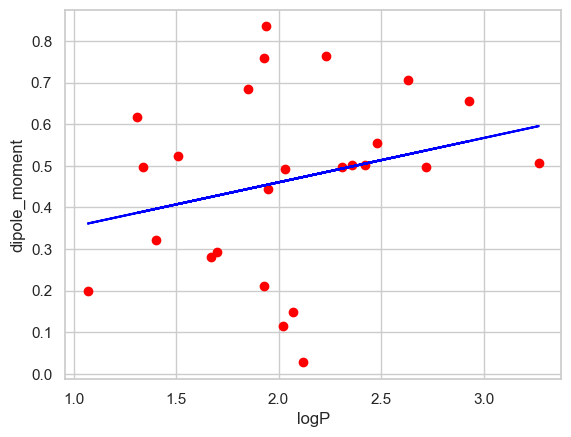

Amount of feature: nHRing: 3
R^2 score: 0.17344283536923205
{'mse': 0.246, 'mae': 0.385, 'r_score': 0.173}


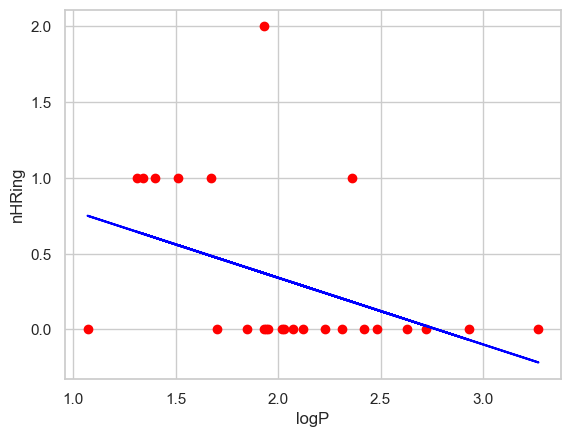

Kruskal for nHRing: 6.76
P-value: 0.0340
There is a statistically significant difference between the groups


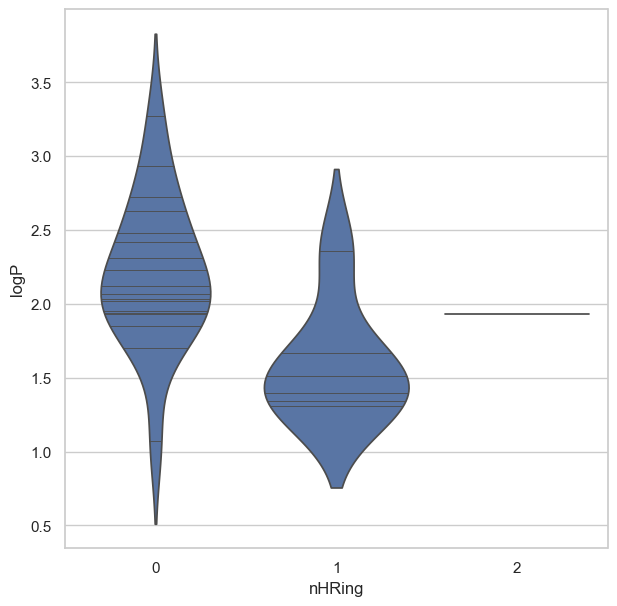

Amount of feature: nO: 2
R^2 score: 0.0021642147112517535
{'mse': 0.038, 'mae': 0.077, 'r_score': 0.002}


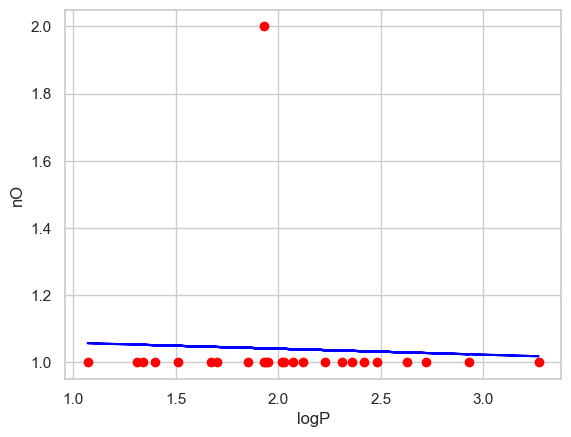

Mann-Whitney U for nO: 15.50
P-value: 0.6773
There isn't any statistically significant difference between the groups


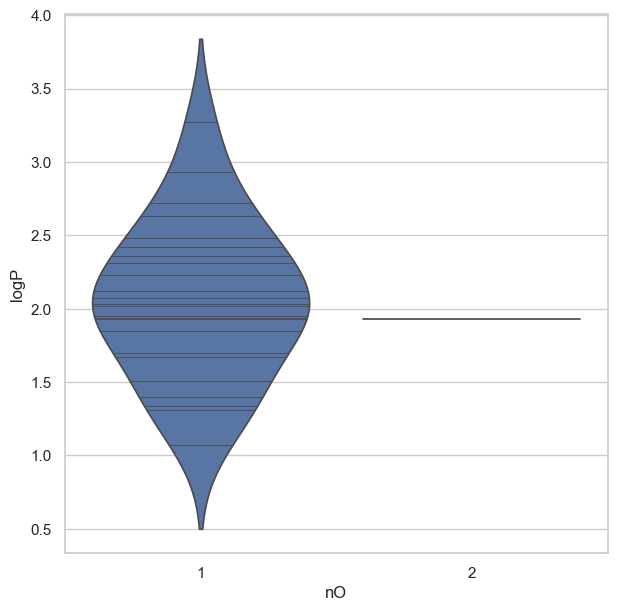

Amount of feature: PBF: 25
R^2 score: 0.1768668781430266
{'mse': 0.02, 'mae': 0.115, 'r_score': 0.177}


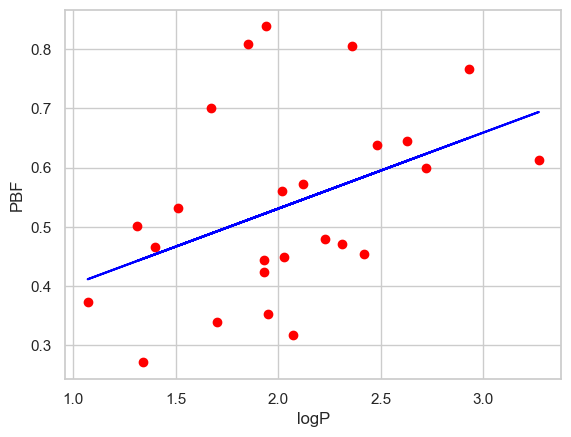

Amount of feature: nC: 7
R^2 score: 0.33296021630808703
{'mse': 1.298, 'mae': 0.957, 'r_score': 0.333}


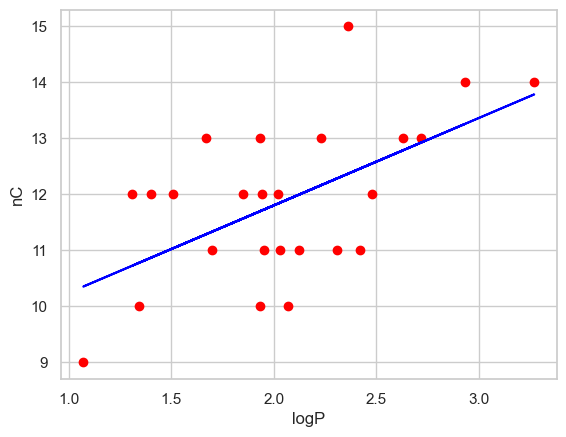

Kruskal for nC: 11.77
P-value: 0.0672
There isn't any statistically significant difference between the groups


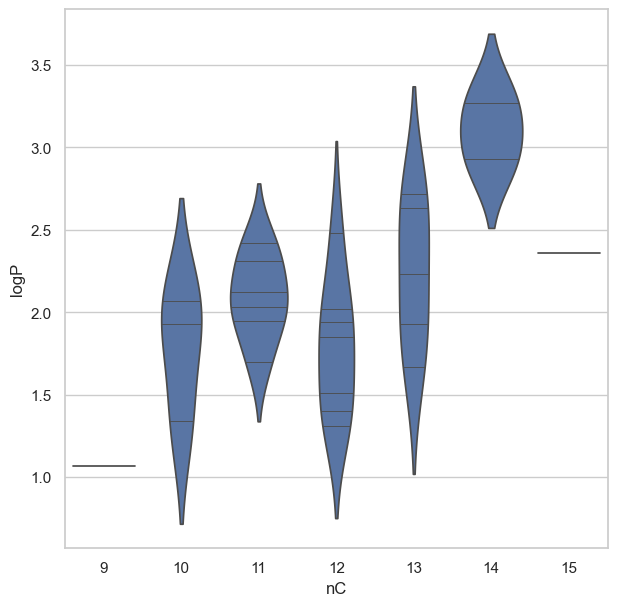

Amount of feature: angle_X2X1R1: 16
R^2 score: 0.26644862624921456
{'mse': 372.567, 'mae': 16.676, 'r_score': 0.266}


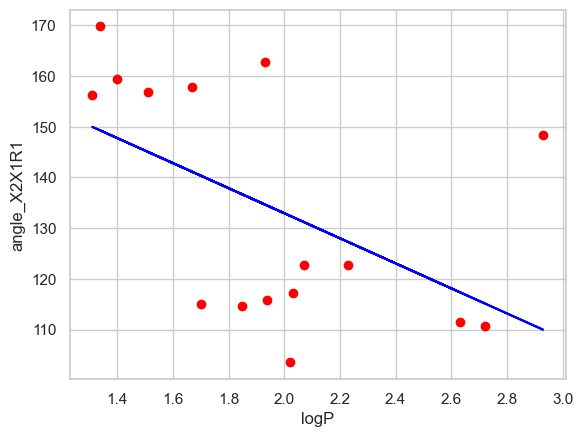

Amount of feature: nARing: 4
R^2 score: 0.1619932758185369
{'mse': 0.357, 'mae': 0.41, 'r_score': 0.162}


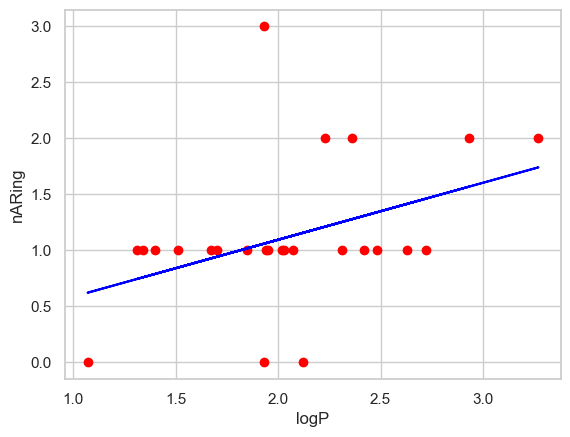

Kruskal for nARing: 6.53
P-value: 0.0885
There isn't any statistically significant difference between the groups


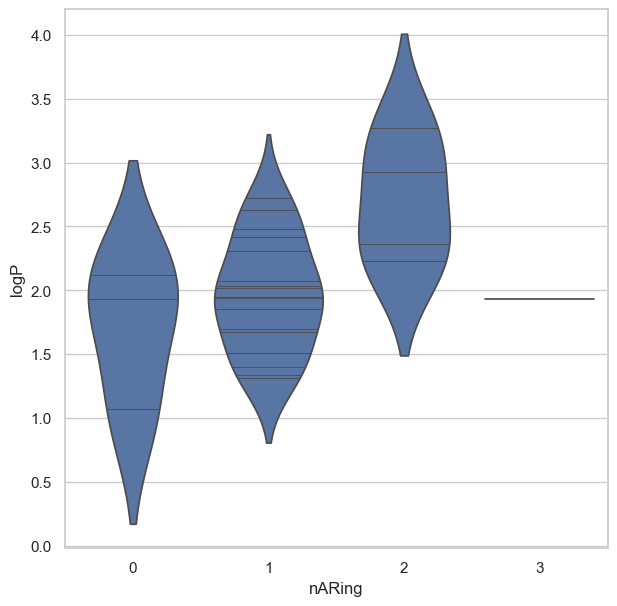

Amount of feature: angle_R2X2R1: 16
R^2 score: 0.06846752130970164
{'mse': 567.678, 'mae': 22.091, 'r_score': 0.068}


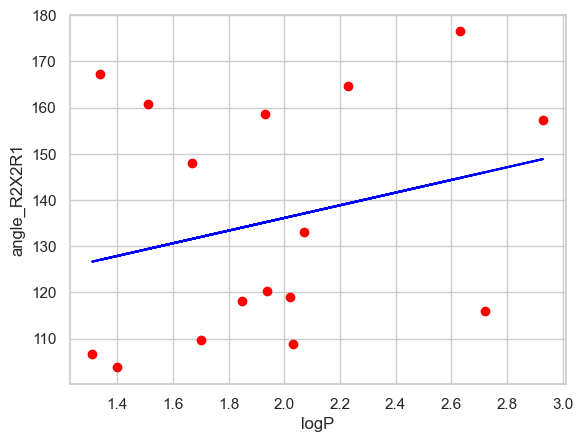

Amount of feature: cis/trans: 3
R^2 score: 0.006332750403308409
{'mse': 0.547, 'mae': 0.571, 'r_score': 0.006}


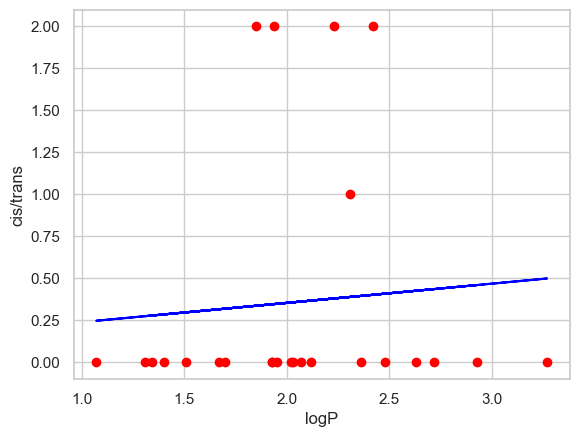

Kruskal for cis/trans: 0.61
P-value: 0.7370
There isn't any statistically significant difference between the groups


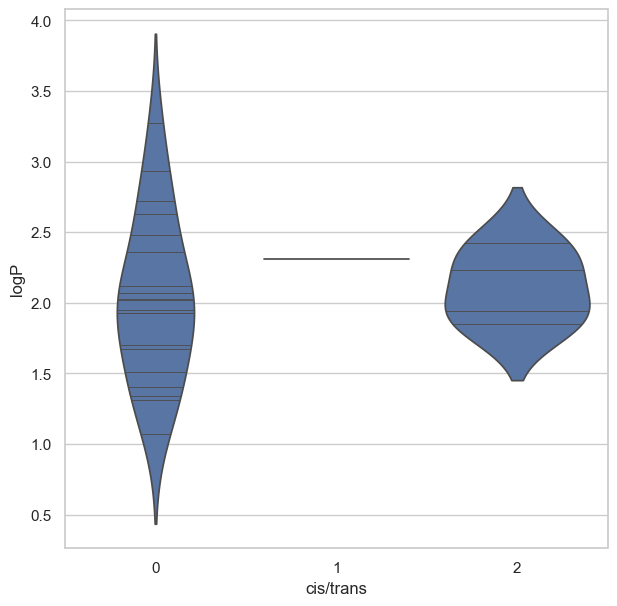

Amount of feature: PNSA5: 25
R^2 score: 0.1141514649517983
{'mse': 25.45, 'mae': 4.26, 'r_score': 0.114}


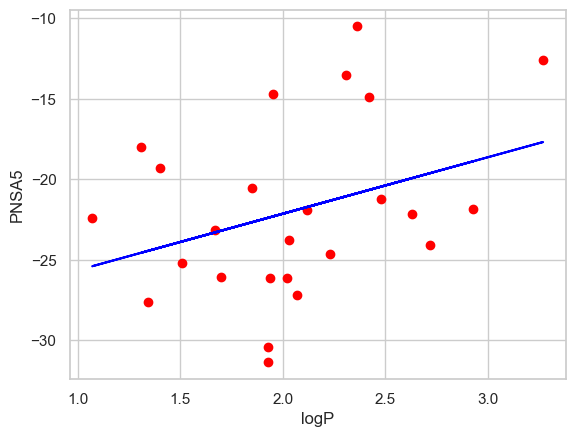

Amount of feature: FPSA3: 25
R^2 score: 0.2914124736297375
{'mse': 0.0, 'mae': 0.002, 'r_score': 0.291}


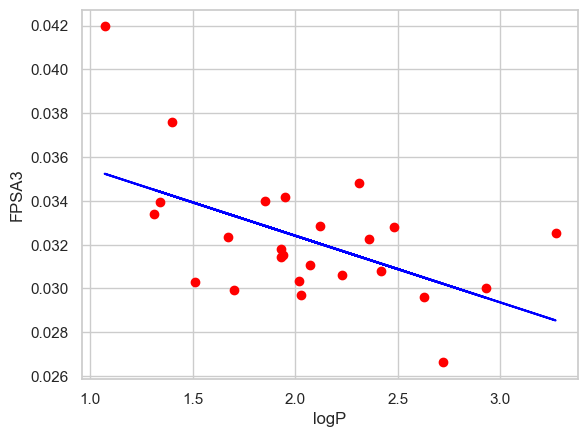

Amount of feature: mol_volume: 25
R^2 score: 0.2817406478141283
{'mse': 260.492, 'mae': 13.656, 'r_score': 0.282}


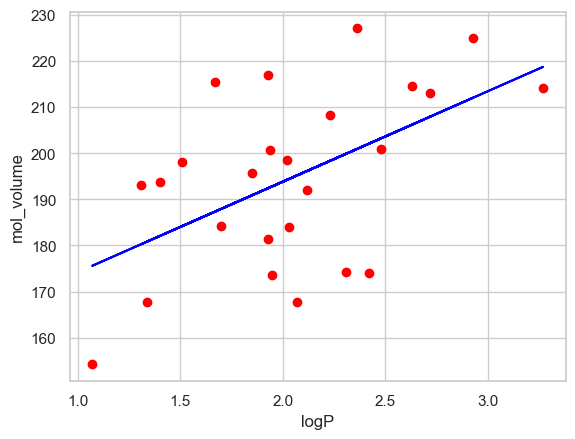

Amount of feature: RPCS: 23
R^2 score: 0.13282031408948874
{'mse': 171.638, 'mae': 11.654, 'r_score': 0.133}


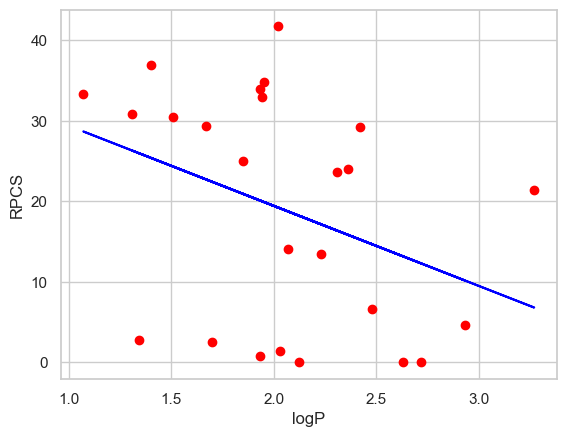

Amount of feature: GeomShapeIndex: 25
R^2 score: 0.18595343781077017
{'mse': 0.003, 'mae': 0.048, 'r_score': 0.186}


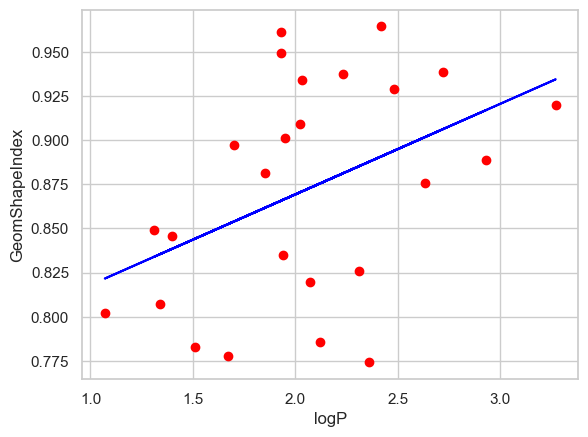

Amount of feature: WPSA5: 25
R^2 score: 0.2350338520456743
{'mse': 0.332, 'mae': 0.426, 'r_score': 0.235}


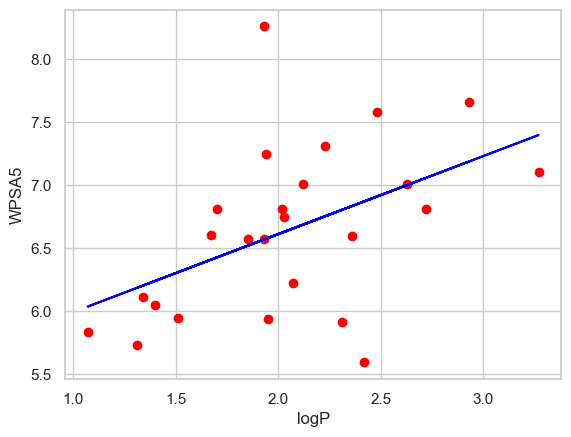

Amount of feature: TASA: 25
R^2 score: 0.3805566564830039
{'mse': 882.472, 'mae': 23.999, 'r_score': 0.381}


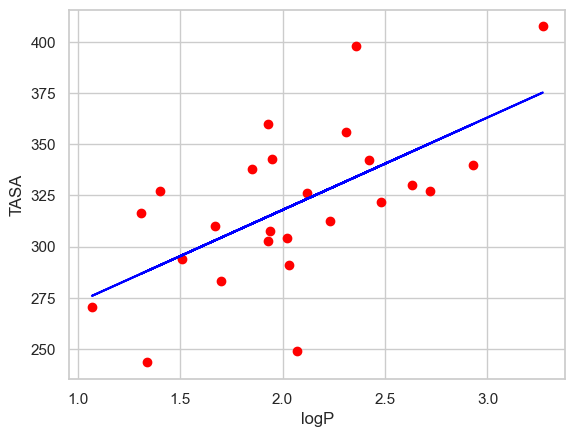

Amount of feature: f_to_fg: 3
R^2 score: 0.0760513176981866
{'mse': 0.591, 'mae': 0.694, 'r_score': 0.076}


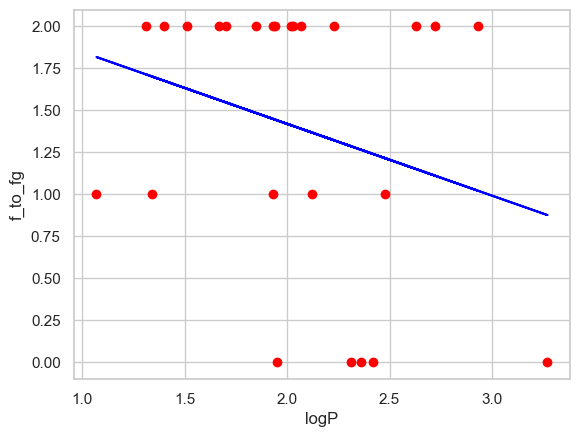

Kruskal for f_to_fg: 4.14
P-value: 0.1261
There isn't any statistically significant difference between the groups


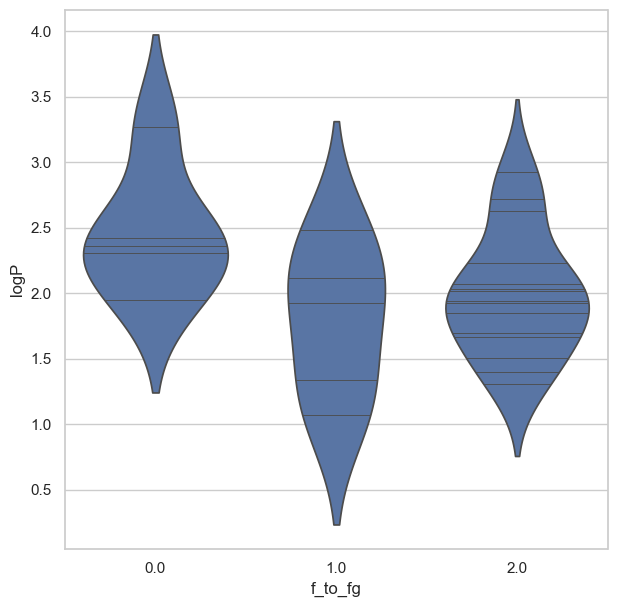

Amount of feature: dihedral_angle: 16
R^2 score: 0.00670857346838702
{'mse': 4290.883, 'mae': 55.933, 'r_score': 0.007}


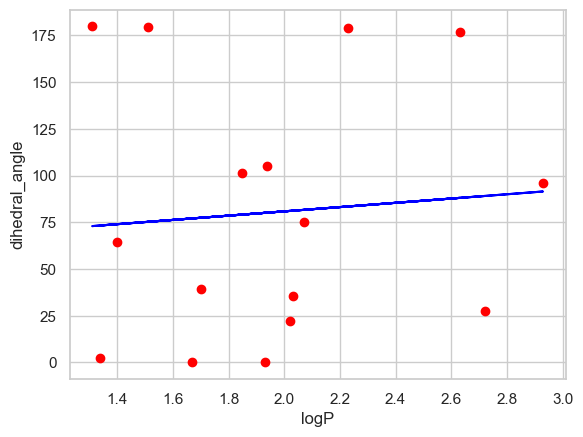

Amount of feature: distance_between_atoms_in_f_group_centers: 16
R^2 score: 0.14909991084193785
{'mse': 0.641, 'mae': 0.702, 'r_score': 0.149}


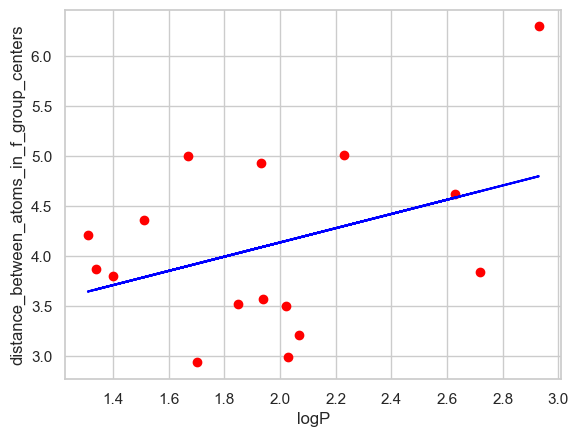

Amount of feature: avg_atoms_in_cycle: 7
R^2 score: 0.12044397384498513
{'mse': 0.519, 'mae': 0.543, 'r_score': 0.12}


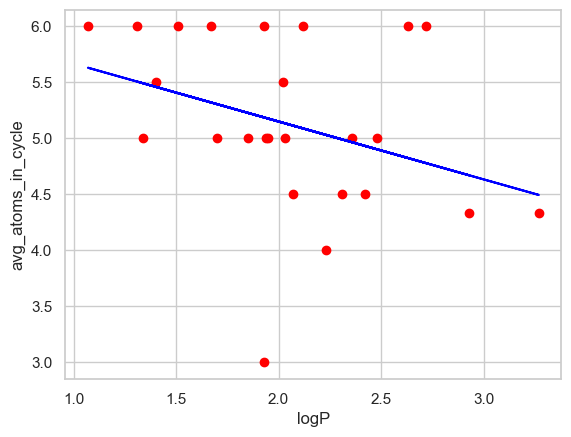

Kruskal for avg_atoms_in_cycle: 8.43
P-value: 0.2085
There isn't any statistically significant difference between the groups


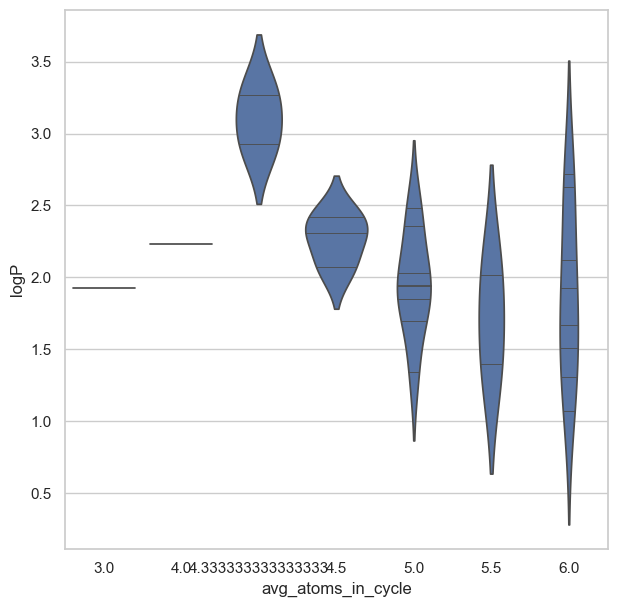

Amount of feature: angle_X1X2R2: 16
R^2 score: 0.09627919005091072
{'mse': 365.305, 'mae': 15.401, 'r_score': 0.096}


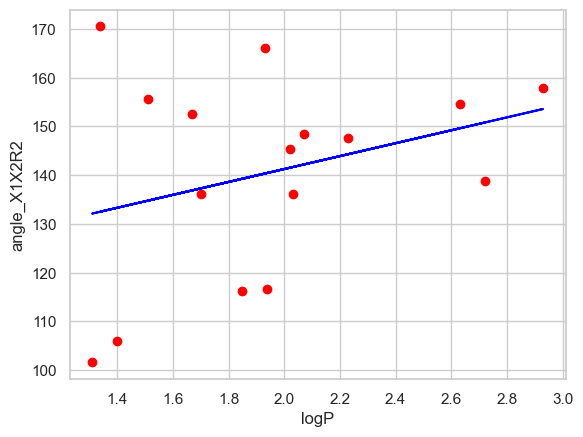

Amount of feature: nFHRing: 2
R^2 score: 0.003098253981450158
{'mse': 0.073, 'mae': 0.147, 'r_score': 0.003}


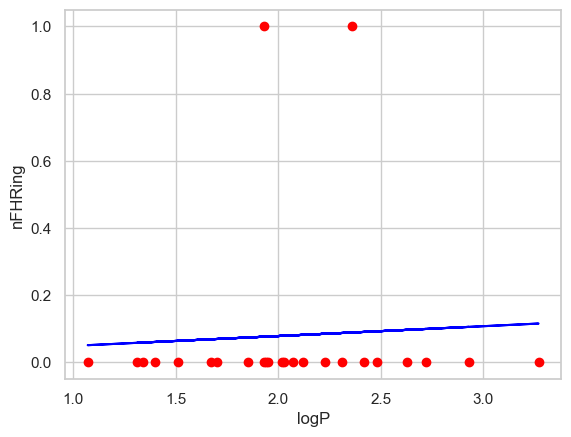

Mann-Whitney U for nFHRing: 20.50
P-value: 0.8412
There isn't any statistically significant difference between the groups


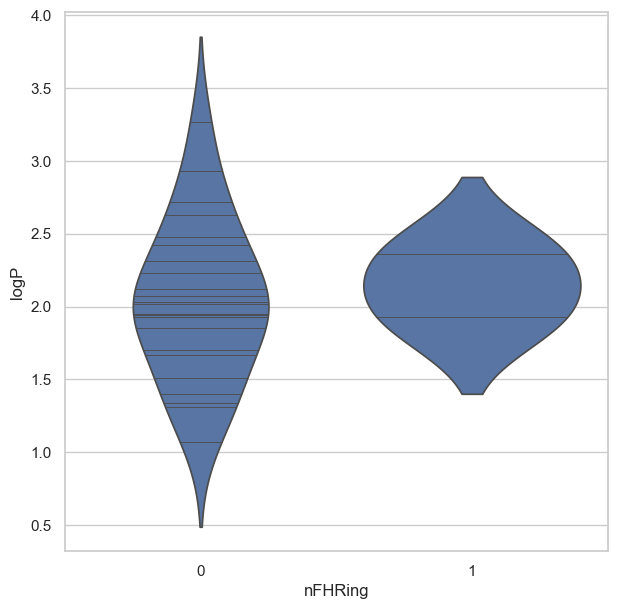

Amount of feature: chirality: 4
R^2 score: 0.01612640659734058
{'mse': 0.809, 'mae': 0.782, 'r_score': 0.016}


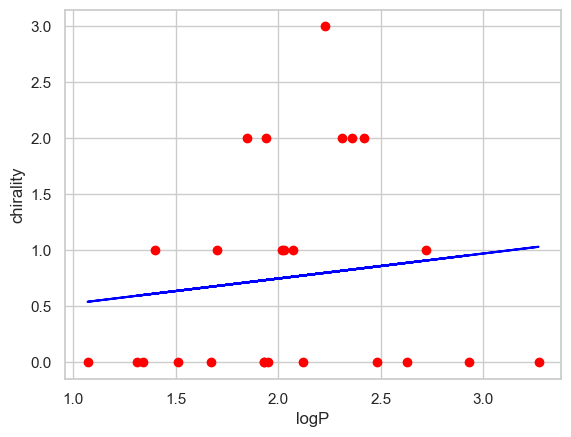

Kruskal for chirality: 0.99
P-value: 0.8025
There isn't any statistically significant difference between the groups


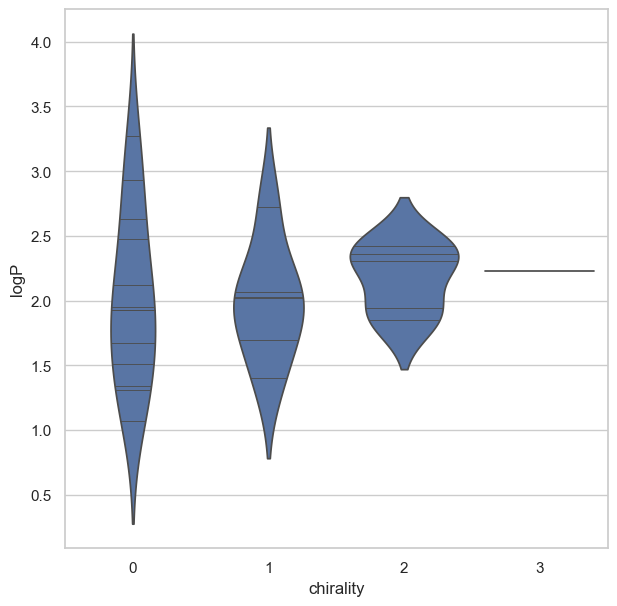

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, mannwhitneyu, kruskal
import seaborn

seaborn.set_theme(style = 'whitegrid') 


def complete_mannwhitneyu_test(values1, values2, feature_name):
    result = mannwhitneyu(values1, values2, alternative='two-sided')

    print(f"Mann-Whitney U for {feature_name}: {result.statistic:.2f}")
    print(f"P-value: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print("There is a statistically significant difference between the groups")
    else:
        print("There isn't any statistically significant difference between the groups")


def complete_kruskal_test(groups, feature_name):
    result = kruskal(*groups)

    print(f"Kruskal for {feature_name}: {result.statistic:.2f}")
    print(f"P-value: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print("There is a statistically significant difference between the groups")
    else:
        print("There isn't any statistically significant difference between the groups")


feature_names = df_features.columns

for factor_index in range(n_factors):
    factor_representation = fa.loadings_[:, factor_index]

    for feature_index in range(len(feature_names)):
        if abs(factor_representation[feature_index]) < 0.0:
            continue

        if feature_names[feature_index] == 'logP':
            continue
        
        feature_name = feature_names[feature_index]
        # print(f"Factor: {factor_index}, feature: {feature_names[feature_index]}, representation: {factor_representation[feature_index]}, logP repsentation: {factor_representation[-1]}")

        _x = list(df_features['logP'])
        _y = list(df_features[feature_names[feature_index]])
        x, y = [], []
        for index in range(len(_x)):
            if _y[index] == 0 and ("angle" in feature_names[feature_index] or "distance" in feature_names[feature_index]):
                continue
            else:
                x.append(_x[index])
                y.append(_y[index])


        print(f"Amount of feature: {feature_name}: {len(set(y))}")
        # if len(set(y)) > 10:
        slope, intercept, r, p, se = linregress(x, y)
        y_line = [slope * xi + intercept for xi in x]

        print(f"R^2 score: {pow(r, 2)}")
        print(calculate_metrics(y, y_line))

        plt.scatter(x=x, y=y, color="red")
        plt.plot(x, y_line, color="blue")
        plt.xlabel('logP')
        plt.ylabel(feature_names[feature_index])
        plt.show()
        # break

        if len(set(y)) < 10:

            df_dict = {}
            vals, names, xs = [],[],[]
            for i, unique_values in enumerate(sorted(set(y))):
                values = df_features[df_features[feature_name] == unique_values]['logP']
                vals.append(values)
                names.append(f"{feature_name}: {i}")
                df_dict[f"{feature_name}: {unique_values}"] = values
                xs.append(np.random.normal(unique_values, 0.08, values.shape[0])) 

            if len(set(y)) == 2:
                values1 = df_features[df_features[feature_name] == list(set(y))[0]]['logP']
                values2 = df_features[df_features[feature_name] == list(set(y))[1]]['logP']
                complete_mannwhitneyu_test(values1=values1, 
                                           values2=values2, 
                                           feature_name=feature_name)
            else:
                complete_kruskal_test(groups=vals, 
                                      feature_name=feature_name)
            
            df = pd.DataFrame(df_dict)

            plt.figure(figsize=(7,7))
            seaborn.violinplot(x=feature_name, y ='logP',
                               data = df_features,
                               inner="stick")
            plt.show()

    break        
                
